In [9]:
import os
from rosemary import jpt_setup; jpt_setup()

import matplotlib.pyplot as plt


from transformers.trainer_utils import get_last_checkpoint

import re
from llm.submit import (
    multiline_to_singleline,
    submit_job_ccc,
    submit_job_aimos,
    submit_job,
    get_run_statistics)
import pandas as pd
pd.set_option('display.max_colwidth', None)

import numpy as np
import json
import platform
import tempfile
import subprocess
import shlex
import datetime
import itertools
import socket
import glob

import base64
string_to_alphanumeric = lambda s: base64.urlsafe_b64encode(s.encode('utf-8')).decode('utf-8')
alphanumeric_to_string = lambda a: base64.urlsafe_b64decode(a).decode('utf-8')

arch = platform.uname().processor
hostname = socket.gethostname()
cluster = 'ccc' if hostname.startswith('ccc') else ('dcs' if hostname.startswith('dcs') else 'npl')
arch, cluster

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


('ppc64le', 'dcs')

# Finetuning with openinstruct/finetune.py


In [10]:
# job_name = 'ft'
# test_run = 1
# test_run = bool(test_run)

# queue = 'x86_12h' # 'x86_12h'
# num_cpus = 20
# num_gpus = 1
# cpu_mem = 32
# require = 'a100_80gb'

# # model_name_or_path = 'mosaicml/mpt-7b'; max_seq_length = 2048
# # model_name_or_path = 'gpt2'; max_seq_length = 1024
# # model_name_or_path = 'gpt2-Large'; max_seq_length = 1024
# # model_name_or_path = 'gpt2-xl'; max_seq_length = 1024
# model_name_or_path = 'huggyllama/llama-7b'; max_seq_length = 2048


# train_file = 'data/processed/oasst1/oasst1_data.jsonl'; train_file_short = 'oasst1'
# train_file = 'data/processed/flanv2_cot_oasst1_dolly.jsonl'; train_file_short = 'human_mix'
# # train_file = 'data/processed/flanv2_cot_oasst1_dolly_shuffled.jsonl'; train_file_short = 'human_mix_shuffled'

# output_dir = f"results/{model_name_or_path.replace('/', ':')}_{train_file_short}"
# if test_run:
#     output_dir = 'jpt_' + output_dir

# use_deepspeed = False
# # deepspeed_config_file = 'ds_configs/stage3_no_offloading_accelerate_setauto.conf'
# # deepspeed_config_file = 'ds_configs/stage3_offloading_accelerate.conf'
# deepspeed_config_file = 'ds_configs/stage3_offloading_accelerate_setauto.conf'

# use_lora = True
# lora_rank = 4
# lora_alpha = lora_rank
# lora_dropout = 0.05

# batch_size_per_gpu = 1
# total_batch_size = 128
# mixed_precision = 'bf16' # 'bf16', 'fp16'
# checkpointing_steps = None # every n steps, where n='1' or every 'epoch'

# gradient_acc_steps = int(total_batch_size/num_gpus/batch_size_per_gpu)

# print(f"Training {model_name_or_path} "
#       f"using {num_gpus} GPUs, "
#       f"{batch_size_per_gpu} batch size per GPU, "
#       f"{gradient_acc_steps} gradient accumulation steps.")

# # do use fast tokenizer since mpt-7b does not have a fast tokenizer counter-part
# #     --use_slow_tokenizer \
# # do not use flash attention, since having problem installing flash-attn with cuda 12.1
# #     --use_flash_attn \

# cmd = f"""
# {'!cd .. && ' if test_run else ''}accelerate launch \
#     --mixed_precision {mixed_precision} \
#     --num_machines 1 \
#     --num_processes {num_gpus} \
#     {'--use_deepspeed' if use_deepspeed else ''}
#     {'--deepspeed_config_file '+deepspeed_config_file if use_deepspeed else ''}
#     open_instruct/finetune.py \
#     --model_name_or_path {model_name_or_path} \
#     --tokenizer_name {model_name_or_path} \
#     --train_file {train_file} \
#     --max_seq_length {max_seq_length} \
#     {'--use_lora' if use_lora else ''}
#     --lora_rank {lora_rank} \
#     --lora_alpha {lora_alpha} \
#     --lora_dropout {lora_dropout} \
#     --preprocessing_num_workers 16 \
#     --per_device_train_batch_size {batch_size_per_gpu} \
#     --gradient_accumulation_steps {gradient_acc_steps} \
#     --learning_rate 2e-5 \
#     --lr_scheduler_type linear \
#     --warmup_ratio 0.03 \
#     --weight_decay 0. \
#     --num_train_epochs 2 \
#     --output_dir {output_dir} \
#     --with_tracking \
#     --report_to tensorboard \
#     {'--checkpointing_steps '+str(checkpointing_steps) if checkpointing_steps else ''}
#     --logging_steps 1
# """

# # things to test to see its effects on (1) eval perf (2) runtime.
# #
# # - int8
# # - mixed_precision bf16 or no
# # - with/without LoRA
# # - LoRA's rank/alpha (alpha typically set to 2*rank)
# # - batch size
# # - micro-batch size (largest without running out of memory)


# cmd = multiline_to_singleline(cmd)
# if test_run:
#     print()
#     print(cmd)

# shell_scripts = shell_scripts_template.format(
#     cmd=cmd,
#     log_dir=os.getcwd(),
#     save_dir=output_dir)
# out = submit_job_ccc(
#     shell_scripts, 
#     job_name=job_name, 
#     queue=queue,
#     num_cpus=num_cpus,
#     cpu_mem=cpu_mem,
#     require=require,
#     num_gpus=num_gpus,
#     test_run=test_run,
# )
# if not test_run:
#     print(out)

# Finetuning with openinstruct/finetune_trainer.py


In [11]:
shell_scripts_template_slurm = """
echo "Running on $SLURM_JOB_NODELIST"
echo "======"

master_addr=$(scontrol show hostnames "$SLURM_JOB_NODELIST" | head -n 1)
master_port=10002
RDZV_ENDPOINT=$master_addr:$master_port

source ~/.profile
conda activate open-instruct
cd /gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/

set -e
set -x
echo "======"
srun {cmd}

[ ! -f "{log_dir}/$SLURM_JOB_ID*.out" ] && mv {log_dir}/$SLURM_JOB_ID*.out {save_dir}
"""

shell_scripts_template_lsf = """
echo "Running on $LSB_DJOB_HOSTFILE"
echo "======"

master_addr=$(head -n 1 "$LSB_DJOB_HOSTFILE")
master_port=10002
RDZV_ENDPOINT=$master_addr:$master_port

source ~/.profile
conda activate open-instruct
cd /dccstor/mit_fm/wpq/github/mitibm2023/external/open-instruct/

set -e
set -x
echo "======"
srun {cmd}

[ ! -f "{log_dir}/$LSB_JOBID*.out" ] && mv {log_dir}/$LSB_JOBID*.out {save_dir}
"""

shell_scripts_template = shell_scripts_template_slurm \
    if arch == 'ppc64le' else shell_scripts_template_lsf

print(shell_scripts_template)


echo "Running on $SLURM_JOB_NODELIST"
echo "======"

master_addr=$(scontrol show hostnames "$SLURM_JOB_NODELIST" | head -n 1)
master_port=10002
RDZV_ENDPOINT=$master_addr:$master_port

source ~/.profile
conda activate open-instruct
cd /gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/

set -e
set -x
echo "======"
srun {cmd}

[ ! -f "{log_dir}/$SLURM_JOB_ID*.out" ] && mv {log_dir}/$SLURM_JOB_ID*.out {save_dir}



In [4]:
t = '00:33:12'
n = 15
# total = 1515; nnodes = 1
# total = 2083; nnodes = 1
total = 1587; nnodes = 1
# total = 1041; nnodes = 1
# total = 4228; nnodes = 1
# total = 4512; nnodes = 4
# total = 4296; nnodes = 1
# total = 2254; nnodes = 2
# total = 1128; nnodes = 4
# total = 1074; nnodes = 4
# total = 1252; nnodes = 4

l = [int(x) for x in t.split(':')]
t = l[0]*60*60+l[1]*60+l[2]
# t = t/60/60 # in hr

print(f'{t/n/nnodes:.0f}s/it, {t/n*total/60/60:.1f}hrs')

133s/it, 58.5hrs


In [ ]:
l = []
p = '../data/processed/'
for x in os.listdir(p):
    y = os.path.join(p, x)
    if os.path.isdir(y):
        d = os.path.join(y, os.listdir(y)[0])
    else:
        continue
    d = d[3:]
    if 'shuffled' in d:
        continue
#     print(f"train_file = '{d}'; abbr_train_file = '{x}'")
    print(x)

In [ ]:


# how to sample mixture sample size?
# 
# approaches: 
# (1) want sufficient coverage for #datapoints/dataset, #datasets used, total sample size.
#  Use 5k as a unit of data, sample different #unit/dataset, and vary total units of data.
# (2) specify a total sample size and a mixture weight. this answers the question, given a 
#  fixed compute budget, what is the optimal mixture. this seems to be a simpler approach.
#
# experiments
# (1) first use samples from a single dataset for tuning. 
# (2)
# 


datasets = ['baize', 'code_alpaca', 'cot', 'dolly', 'flan_v2', 'gpt4_alpaca', 'oasst1', 'self_instruct', 'sharegpt', 'stanford_alpaca', 'super_ni', 'unnatural_instructions']
total_data_points = 200000

subsample_mixture_list = []
subsample_mixture_list += [
    {k: 100000} for k in datasets if k != 'flan_v2'
]
subsample_mixture_list += [
    {k: int(total_data_points/4) for k in ['cot', 'flan_v2', 'dolly', 'oasst1']}
]
subsample_mixture_list += [
    dict((k, int(v*total_data_points)) for k, v in
    {'cot': 0.48785105, 'flan_v2': 0.48785105, 'dolly': 0.00732313, 'oasst1': 0.01697478}.items())
]
subsample_mixture_list += [
    {k: int(total_data_points/len(datasets)) for k in datasets} 
]
subsample_mixture_list += [
    dict((k, int(v*total_data_points)) for k, v in
    {'cot': .07678, 'flan_v2': .9137, 'dolly': .004471, 'oasst1': .009072}.items())
]
subsample_mixture_list += [
    dict((k, int(v*total_data_points)) for k, v in
    {'cot': 0.1127, 'flan_v2': 0.8726, 'dolly': 0.01395, 'oasst1': 0.001391}.items())
]
subsample_mixture_list

In [5]:
## Clean up checkpoints `optimizer.bin` to save disk space. 
# (e.g., 7b model, ~8*7=56GB for storing gradient/momentum in `optimizer.bin`)

import glob, os

def cleanup_checkpoints(save_dir, test_run=False):

    checkpoints = glob.glob(os.path.join(save_dir, 'checkpoint-*'))
    checkpoints = sorted(checkpoints, key=lambda x: int(x.split('-')[-1]))
    checkpoints = checkpoints[:-1]
    
    if not checkpoints: return

    for ckpt_path in checkpoints:
        optimizer_bin_path = os.path.join(ckpt_path, 'optimizer.bin')
        if os.path.isfile(optimizer_bin_path):
            print(optimizer_bin_path)
            if not test_run:
                os.remove(optimizer_bin_path)
        
        
test_run = False
exp_dirs = ['../results/ft2',
            '../results/oi3']

print('Remove extra files (e.g., optimizer.bin) for non-latest checkpoints:')

for exp_dir in exp_dirs:
    for run_name in os.listdir(exp_dir):
        save_dir = os.path.join(exp_dir, run_name)
        if os.path.islink(save_dir): continue
        cleanup_checkpoints(save_dir, test_run=test_run)

Remove extra files (e.g., optimizer.bin) for non-latest checkpoints:
../results/oi3/llama-7b_all:400k_humanmix/checkpoint-50/optimizer.bin
../results/oi3/llama-7b_all:400k_humanmix/checkpoint-100/optimizer.bin
../results/oi3/llama-7b_all:400k_humanmix/checkpoint-150/optimizer.bin
../results/oi3/llama-7b_all:400k_humanmix/checkpoint-200/optimizer.bin
../results/oi3/llama-7b_all:400k_humanmix/checkpoint-250/optimizer.bin
../results/oi3/llama-7b_all:400k_humanmix/checkpoint-300/optimizer.bin
../results/oi3/llama-7b_all:400k_humanmix/checkpoint-350/optimizer.bin
../results/oi3/llama-7b_all:400k_humanmix/checkpoint-400/optimizer.bin
../results/oi3/llama-7b_all:400k_humanmix/checkpoint-450/optimizer.bin
../results/oi3/llama-7b_all:400k_humanmix/checkpoint-500/optimizer.bin
../results/oi3/llama-7b_all:400k_humanmix/checkpoint-550/optimizer.bin
../results/oi3/llama-7b_all:400k_humanmix/checkpoint-600/optimizer.bin
../results/oi3/llama-7b_all:400k_humanmix/checkpoint-650/optimizer.bin
../result

In [15]:
def compute_mixture_num_samples(mixture, max_train_samples):
    s = sum(mixture.values())
    mixture = {k: int(max_train_samples*v/s) for k, v in mixture.items()}
    return mixture

num_cpus = 144 if arch == 'ppc64le' else 32
cpu_mem =  512 if arch == 'ppc64le' else 64

max_train_samples = 200000 # 10000, 50000, 100000, 200000
# max_train_samples = 600000

save_strategy = 'steps'
save_steps = 100; save_total_limit = 1


subsample_mixture_list = []
# subsample_mixture_list += [
#     {k: max_train_samples} for k in datasets
# ]
# subsample_mixture_list += [
#     {k: int(max_train_samples/4) for k in ['cot', 'flan_v2', 'dolly', 'oasst1']}
# ]
# subsample_mixture_list += [
#     ('humanmix', dict((k, int(v*max_train_samples)) for k, v in
#     {'cot': 0.48785105, 'flan_v2': 0.48785105, 'dolly': 0.00732313, 'oasst1': 0.01697478}.items()))
# ] # humanmix mixture.
# subsample_mixture_list += [
#     {k: int(max_train_samples/len(datasets)) for k in datasets} 
# ]
# subsample_mixture_list += [
#     dict((k, int(v*max_train_samples)) for k, v in
#     {'cot': .07678, 'flan_v2': .9137, 'dolly': .004471, 'oasst1': .009072}.items())
# ]
# subsample_mixture_list += [
#     dict((k, int(v*max_train_samples)) for k, v in
#     {'cot': 0.1127, 'flan_v2': 0.8726, 'dolly': 0.01395, 'oasst1': 0.001391}.items())
# ]
# subsample_mixture_list += [
#     dict((k, int(v*max_train_samples)) for k, v in
#     {'cot':  0.13568177819252014, 'flan_v2': 0.3957784175872803, 
#      'dolly': 0.05964866653084755, 'oasst1': 0.4088916480541229}.items())
# ] # gpt2-medium_humanmix_uniform:200k_doremiv2.json

# subsample_mixture_list += [
#     dict((k, int(v*max_train_samples)) for k, v in
#     {"cot": 0.360595703125, "dolly": 0.0021991729736328125, "flan_v2": 0.63037109375, "oasst1": 0.0016956329345703125}.items())
# ] # pythia-1.4b humanmix_uniform:200k_doremiv1.json

# subsample_mixture_list += [
#     dict((k, int(v*max_train_samples)) for k, v in
#     {"cot": 0.2254638671875, "dolly": 0.01409149169921875, "flan_v2": 0.1739501953125, "oasst1": 0.59423828125}.items())
# ] # pythia-1.4b humanmix_uniform:200k_doremiv2.json

# subsample_mixture_list += [
#     dict((k, int(v*max_train_samples)) for k, v in
#     {"cot": 0.08563232421875, "dolly": 0.54296875, "flan_v2": 0.347900390625, "oasst1": 0.0103302001953125}.items())
# ] # llama-7b_humanmix_uniform:200k_doremiv2.json

# subsample_mixture_list += [
#     dict((k, int(v*max_train_samples)) for k, v in
#     {"cot": 0.0316162109375, "dolly": 0.204833984375, "flan_v2": 0.40966796875, "oasst1": 0.40966796875}.items()
#         )] # llama-7b_humanmix_uniform:600k_doremiv2.json

subsample_mixture_normalized_list = []
# subsample_mixture_normalized_list += [('uniform:1200k_doremiv2', # llama-7b_humanmix_uniform:1200k_doremiv2.json
#                                        {"cot": 0.11419677734375, "dolly": 0.1024169921875, "flan_v2": 0.204833984375, "oasst1": 0.204833984375})]
## 10 for trying out datamodels
# mixes = [{'cot': 0.37664033529374275,
#   'dolly': 0.0874640765523398,
#   'flan_v2': 0.39740799933549775,
#   'oasst1': 0.1384875888184196},
#  {'cot': 0.23064419241874784,
#   'dolly': 0.04693354147889885,
#   'flan_v2': 0.72121745986295,
#   'oasst1': 0.0012048062394032465},
#  {'cot': 0.11244721555034376,
#   'dolly': 0.21997027355988638,
#   'flan_v2': 0.5826671754210359,
#   'oasst1': 0.08491533546873392},
#  {'cot': 0.27704626812045546,
#   'dolly': 0.5712282144637615,
#   'flan_v2': 0.024940119654536592,
#   'oasst1': 0.12678539776124645},
#  {'cot': 0.0024519793352964607,
#   'dolly': 0.13274603201304974,
#   'flan_v2': 0.012268378167304219,
#   'oasst1': 0.8525336104843496},
#  {'cot': 0.08065633865016615,
#   'dolly': 0.41886215168938545,
#   'flan_v2': 0.21723932820070485,
#   'oasst1': 0.2832421814597436},
#  {'cot': 0.13878643021160036,
#   'dolly': 0.05686171157146557,
#   'flan_v2': 0.6701353469446995,
#   'oasst1': 0.13421651127223455},
#  {'cot': 0.2461125374866837,
#   'dolly': 0.09774240280444893,
#   'flan_v2': 0.13974091986040005,
#   'oasst1': 0.5164041398484672},
#  {'cot': 0.4069781049152398,
#   'dolly': 0.06318759506033228,
#   'flan_v2': 0.09504719644992135,
#   'oasst1': 0.4347871035745066},
#  {'cot': 0.22379693013848484,
#   'dolly': 0.30565901275011814,
#   'flan_v2': 0.15457716965000887,
#   'oasst1': 0.31596688746138824}]

# mixes = [
#     {'cot': 0.46638974, 'dolly': 0.01456044, 'flan_v2': 0.50886009, 'oasst1': 0.01018973},
#     {'cot': 0.39744481, 'dolly': 0.00472114, 'flan_v2': 0.59104177, 'oasst1': 0.00679229},
# ]

# subsample_mixture_normalized_list += [('', d) for d in mixes]
# subsample_mixture_normalized_list += [('humanmix', # humanmix
#                                        {'cot': 0.48785105, 'dolly': 0.00732313, 'flan_v2': 0.48785105, 'oasst1': 0.01697478})]
subsample_mixture_normalized_list = [(x[0],  compute_mixture_num_samples(x[1], max_train_samples)) 
                                     for x in subsample_mixture_normalized_list]
subsample_mixture_list += subsample_mixture_normalized_list

subsample_inds_file_list = []


train_file = 'data/processed/all.jsonl'; abbr_train_file = 'all'
# train_file = 'data/processed/flanv2_cot_oasst1_dolly.jsonl'; abbr_train_file = 'humanmix'
# train_file = 'data/processed/dolly_oasst1.jsonl'; abbr_train_file = 'dolly:oasst1'
# train_file = 'data/processed/cot_flanv2.jsonl'; abbr_train_file = 'cot:flanv2'

# train_file = 'data/processed/super_ni/super_ni_data.jsonl'; abbr_train_file = 'super_ni'
# train_file = 'data/processed/cot/cot_data.jsonl'; abbr_train_file = 'cot'
# train_file = 'data/processed/flan_v2/flan_v2_data.jsonl'; abbr_train_file = 'flan_v2'
# train_file = 'data/processed/dolly/dolly_data.jsonl'; abbr_train_file = 'dolly'
# train_file = 'data/processed/oasst1/oasst1_data.jsonl'; abbr_train_file = 'oasst1'

# train_file = 'data/processed/stanford_alpaca/stanford_alpaca_data.jsonl'; abbr_train_file = 'stanford_alpaca'
# train_file = 'data/processed/baize/baize_data.jsonl'; abbr_train_file = 'baize'
# train_file = 'data/processed/self_instruct/self_instruct_data.jsonl'; abbr_train_file = 'self_instruct'

# train_file = 'data/processed/code_alpaca/code_alpaca_data.jsonl'; abbr_train_file = 'code_alpaca'
# train_file = 'data/processed/unnatural_instructions/unnatural_instructions_data.jsonl'; abbr_train_file = 'unnatural_instructions'
# train_file = 'data/processed/sharegpt/sharegpt_data.jsonl'; abbr_train_file = 'sharegpt'
# train_file = 'data/processed/gpt4_alpaca/gpt4_alpaca_data.jsonl'; abbr_train_file = 'gpt4_alpaca'

def subsample_inds_file_abbr_fn(x):
    return os.path.basename(x).split('.')[0]

max_train_samples_list = [200000]
num_train_epochs_list = [1]



# ft1: reproduce open-instruct table with llama7b
job_name = 'ft1'

# ft2: test mixture weights
# vary mixture weights
job_name = 'ft2'

# oi3: instruction tuning performance w.r.t. steps.
job_name = 'oi3'

# # oi4: data pruning 
# job_name = 'oi4'
# train_file = 'data/processed/flan_v2/flan_v2_data.jsonl'; abbr_train_file = 'flan_v2'
# subsample_mixture_list = [('',None)]
# max_train_samples_list = [int(pct*100000) for pct in [.1, .3, .5, 1]]; num_train_epochs_list = [2] # note pct=1 just need to run once, it means using all data.
# max_train_samples_list = [int(pct*100000) for pct in [.1, .3]]; num_train_epochs_list = [2]
# max_train_samples_list = [int(pct*100000) for pct in [1]]; num_train_epochs_list = [2]


# script_dir = '/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/'
# subsample_inds_file_list = [
#     # baseline, random (first N) subset 
#     '',
#     # dpp's data subset
#     os.path.join(script_dir, 'note_explore_dpp_llama-7b_flan_v2_subsets_K_cos.pkl'),
#     os.path.join(script_dir, 'note_explore_dpp_llama-7b_flan_v2_subsets_K_cos_oneminusprob.pkl'),
#     os.path.join(script_dir, 'note_explore_dpp_llama-7b_flan_v2_subsets_K_cos_prob.pkl'),
#     # select subset based on llama's prob (increasing/decreasing)
#     os.path.join(script_dir, 'note_explore_dpp_llama-7b_flan_v2_subsets_prob_incr.pkl'),
#     os.path.join(script_dir, 'note_explore_dpp_llama-7b_flan_v2_subsets_prob_decr.pkl'),
#     # data pruning by kmeans
#     os.path.join(script_dir, 'note_explore_dpp_llama-7b_flan_v2_subsets_kmeansl2_100_incr.pkl'),
#     os.path.join(script_dir, 'note_explore_dpp_llama-7b_flan_v2_subsets_kmeansl2_100_decr.pkl'),
#     os.path.join(script_dir, 'note_explore_dpp_llama-7b_flan_v2_subsets_kmeansl2_1000_incr.pkl'),
#     os.path.join(script_dir, 'note_explore_dpp_llama-7b_flan_v2_subsets_kmeansl2_1000_decr.pkl'),
#     os.path.join(script_dir, 'note_explore_dpp_llama-7b_flan_v2_subsets_kmeansl2_10000_incr.pkl'),
#     os.path.join(script_dir, 'note_explore_dpp_llama-7b_flan_v2_subsets_kmeansl2_10000_decr.pkl'),
# ]

# oi4_perf_cross_time: perf cross time.
job_name = 'oi4_perf_cross_time'
save_steps = 50; save_total_limit = 200
train_file = 'data/processed/flan_v2/flan_v2_data.jsonl'; abbr_train_file = 'flan_v2'
subsample_mixture_list = [('',None)]
max_train_samples_list = [int(pct*100000) for pct in [.3]]; num_train_epochs_list = [3]
data_inds_dir = '/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/data_inds/llama-7b/flan_v2/'
subsample_inds_file_list = [
    '',
    os.path.join(data_inds_dir, 'kmeansl2_nc=3000_decr.pkl'),
    os.path.join(data_inds_dir, 'kmeansl2_nc=3000_incr.pkl'),
    os.path.join(data_inds_dir, 'prob_decr.pkl'),
    os.path.join(data_inds_dir, 'prob_incr.pkl'),
]


# # oi4_humanmixv1; data pruning
# job_name = 'oi4_hmv1'
# train_file = 'data/processed/tulu/tulu_v1_human_mix.jsonl'; abbr_train_file = 'hmv1'
# subsample_mixture_list = [('',None)]
# max_train_samples_list = [int(pct*100000) for pct in [.1, .3, .5, 1]]; num_train_epochs_list = [2] # note pct=1 just need to run once, it means using all data.





test_run = 1
test_run = bool(test_run)
debug_mode = test_run

nodes = 5; num_gpus = 6; gpu_type = 'v100'; job_duration = 6 # llama-7b on 100k. data
# nodes = 5; num_gpus = 6; gpu_type = 'v100'; job_duration = 12 # llama-7b on 400k data
# nodes = 5; num_gpus = 6; gpu_type = 'v100'; job_duration = 30 # llama-7b on 600k data

# nodes = 1; num_gpus = 1; gpu_type = 'v100'; job_duration = 6  # gpt2
# nodes = 2; num_gpus = 6; gpu_type = 'v100'; job_duration = 6  # pythia-1.4b
# nodes = 5; num_gpus = 6; gpu_type = 'v100'; job_duration = 6  # pythia-2.8b|6.9b


overwrite_output_dir = True if test_run else False # always continue from ckpt if run from cluster.



hf_models_dir = 'results/baselines/'
# model_name_or_path = 'results/baselines/gpt2-medium'; abbr_model_name = 'gpt2m'; max_seq_length = 1024
model_name_or_path = hf_models_dir+'huggyllama/llama-7b'; abbr_model_name = 'llama-7b'; max_seq_length = 2048
# model_name_or_path = 'results/baselines/NousResearch/Llama-2-7b-hf'; abbr_model_name = 'llama2-7b'; max_seq_length = 2048
# model_name_or_path = 'mosaicml/mpt-7b'; abbr_model_name = 'mpt-7b'; max_seq_length = 2048
# model_name_or_path = hf_models_dir+'EleutherAI/pythia-1.4b'; abbr_model_name = 'pythia-1.4b'; max_seq_length = 2048
# model_name_or_path = hf_models_dir+'EleutherAI/pythia-2.8b'; abbr_model_name = 'pythia-2.8b'; max_seq_length = 2048
# model_name_or_path = hf_models_dir+'EleutherAI/pythia-6.9b'; abbr_model_name = 'pythia-6.9b'; max_seq_length = 2048



per_device_train_batch_size = 2
total_batch_size = 128 # 128
gradient_accumulation_steps = round(total_batch_size/(num_gpus*nodes)/per_device_train_batch_size)
effective_batch_size = per_device_train_batch_size*nodes*num_gpus*gradient_accumulation_steps


optimizer = 'adamw_hf' # 'adafactor'

deepspeed = ''; fsdp = False if num_gpus == 1 else "full_shard auto_wrap"  # full_shard, shard_grad_op
if 'gpt2' in abbr_model_name: fsdp_transformer_layer_cls_to_wrap = 'GPT2Block'
elif 'llama' in abbr_model_name: fsdp_transformer_layer_cls_to_wrap = 'LlamaDecoderLayer'
elif 'mpt' in abbr_model_name: fsdp_transformer_layer_cls_to_wrap = 'MPTBlock'
elif 'pythia' in abbr_model_name: fsdp_transformer_layer_cls_to_wrap = 'GPTNeoXLayer'        
else: raise ValueError('Not sure how to set `fsdp_transformer_layer_cls_to_wrap`')
    
# deepspeed = './ds_configs/ds_zero3_cpu_offload.json'; fsdp = False
# deepspeed = './ds_configs/ds_zero3.json'; fsdp = False
# deepspeed = './ds_configs/stage3_no_offloading.conf'; fsdp = False # error with loading... something wrong with the config.

# fsdp = False; deepspeed = False

if fsdp and deepspeed:
    raise ValueError('either fsdp or deepspeed, not both')

use_lora = False
lora_rank = 256 # test {8, 16, 32, 128} # just [128, 8] for now.
lora_alpha = lora_rank 
lora_dropout = 0.05
if use_lora:
    abbr_model_name += f'+lora(r={lora_rank},a={lora_alpha})'

mixed_precision = 'bf16' if arch == 'x86_64' else 'fp16' # mixed_precision = ''
torch_dtype = 'bfloat16' if arch=='x86_64' else 'float16'; torch_dtype = 'float32'

gradient_checkpointing = True
load_in_8bit = False


print(f"Training {model_name_or_path} "
      f"using {num_gpus} GPUs, "
      f"{per_device_train_batch_size} batch size per GPU, "
      f"{gradient_accumulation_steps} gradient accumulation steps, "
      f"Effective batch size {effective_batch_size}")


if nodes == 1:
    exe = 'python' if num_gpus==1 else \
        f"torchrun --nproc_per_node={num_gpus} --master_port=10002"
else:
    exe = f"torchrun --nnodes={nodes} --nproc_per_node={num_gpus} --rdzv-id=$SLURM_JOB_ID --rdzv-backend=c10d --rdzv-endpoint=$RDZV_ENDPOINT"

if test_run:
    exe = f"CUDA_VISIBLE_DEVICES={','.join(map(str, range(num_gpus)))} {exe}"
if test_run and debug_mode:
    exe = 'TORCH_CPP_LOG_LEVEL=INFO NCCL_DEBUG=INFO LOGLEVEL=INFO ' + exe
    error_file='/gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts/error_file'
    exe = f'TORCHELASTIC_ERROR_FILE={error_file} {exe}'


options_list = itertools.product(
    num_train_epochs_list,
    subsample_mixture_list,
    subsample_inds_file_list,
    max_train_samples_list,
)

output_dirname_list = []
for (num_train_epochs,
     mix_name_and_subsample_mixture,
     subsample_inds_file,
     max_train_samples,) in options_list:
    mix_name, subsample_mixture = mix_name_and_subsample_mixture

    output_dirname = f"{abbr_model_name}_{abbr_train_file}:{int(max_train_samples/1000)}k"
        
    if job_name == 'ft2':
        if subsample_mixture is not None:
            assert(abbr_train_file=='all')
            output_dirname += \
                '_mix='+','.join(f'{k}:{v}' for k,v in subsample_mixture.items())
            
    if job_name == 'oi3':
        output_dirname += '_'+mix_name
        
    if job_name.startswith('oi4'):
        subsample_inds_file_abbr = subsample_inds_file_abbr_fn(subsample_inds_file)
        if subsample_inds_file_abbr:
            output_dirname += f'_{subsample_inds_file_abbr}'
            
            
    if test_run:
        output_dirname = 'jpt_'+output_dirname
            
    # if not test_run:
    #     output_dirname += \
    #         '_ep='+str(num_train_epochs)
    # if not test_run:
    #     output_dirname += \
    #         ('_fsdp='+fsdp.split(' ')[0] if fsdp else '')+\
    #         ('_deepspeed='+os.path.basename(deepspeed).split('.')[0] if deepspeed else '')+\
    #         ('_gradckpt='+str(gradient_checkpointing) if gradient_checkpointing else '')+\
    #         '_mbsz='+str(batch_size_per_gpu)+\
    #         '_dtype='+torch_dtype+\
    #         ('_mp='+str(mixed_precision) if mixed_precision else '_mp=none')+\
    #         '_seqlen='+str(max_seq_length)+\
    #         '_nodes='+str(nodes)
    output_dir = os.path.join('results', job_name, output_dirname)
    
    cmd = f"""
    {'!cd .. && ' if test_run else ''}{exe}
        open_instruct/finetune_trainer.py \
        --model_name_or_path={model_name_or_path} \
        --tokenizer_name={model_name_or_path} \
        {'--load_in_8bit' if load_in_8bit else ''} \
        --use_fast_tokenizer=True \
        --train_file={train_file} \
        --max_seq_length={max_seq_length} \
        {'--max_train_samples='+str(max_train_samples) if max_train_samples else ''} \
        {'--use_lora' if use_lora else ''}
        {'--lora_rank='+str(lora_rank) if use_lora else ''}
        {'--lora_alpha='+str(lora_alpha) if use_lora else ''}
        {'--lora_dropout='+str(lora_dropout) if use_lora else ''}
        --do_train \
        --preprocessing_num_workers=16 \
        --per_device_train_batch_size={per_device_train_batch_size} \
        --gradient_accumulation_steps={gradient_accumulation_steps} \
        --learning_rate=2e-5 \
        --lr_scheduler_type=linear \
        --warmup_ratio=0.03 \
        --weight_decay=0. \
        --optim={optimizer} \
        --evaluation_strategy="no" \
        --logging_steps=1 \
        --save_strategy={save_strategy} \
        --save_steps={save_steps} \
        --save_total_limit={save_total_limit} \
        --num_train_epochs={num_train_epochs} \
        {'--fsdp="'+fsdp+'"' if fsdp else ''}
        {'--fsdp_transformer_layer_cls_to_wrap="'+fsdp_transformer_layer_cls_to_wrap+'"' 
            if fsdp else ''}
        {'--gradient_checkpointing' if gradient_checkpointing  else ''}
        --report_to=tensorboard \
        --torch_dtype={torch_dtype} \
        --dataloader_num_workers=8 \
        {f'--{mixed_precision}=True' if mixed_precision else ''} \
        {'--overwrite_output_dir' if overwrite_output_dir else ''} \
        {'--deepspeed='+deepspeed if deepspeed else ''} \
        {'--subsample_mixture="'+str(subsample_mixture).replace(': ', ':').replace(', ', ',')+'"'
            if subsample_mixture else ''} \
        {'--subsample_inds_file='+subsample_inds_file if subsample_inds_file else ''} \
        --output_dir="{output_dir}" \
    """ 
    #    --overwrite_cache

    cmd = multiline_to_singleline(cmd)
    if test_run:
        print()
        print(cmd)

    shell_scripts = shell_scripts_template.format(
        cmd=cmd,
        log_dir=os.getcwd(),
        save_dir=output_dir)
    out = submit_job(
        shell_scripts, 
        job_name=job_name, 
        nodes=nodes,
        num_cpus=num_cpus,
        cpu_mem=cpu_mem,
        num_gpus=num_gpus,
        gpu_type=gpu_type,
        test_run=test_run,
        job_duration=job_duration,
    )
    if not test_run:
        print(out)

Training results/baselines/huggyllama/llama-7b using 6 GPUs, 2 batch size per GPU, 2 gradient accumulation steps, Effective batch size 120

Submiting job with:
{
    "job_name": "oi4_perf_cross_time",
    "nodes": 5,
    "num_cpus": 144,
    "cpu_mem": 512,
    "num_gpus": 6,
    "gpu_type": "v100",
    "test_run": false,
    "queue": "el8",
    "num_jobs": 1
}
[{'args': 'sbatch --job-name=oi4_perf_cross_time --partition=el8 --nodes=5 --ntasks-per-node=1 --cpus-per-task=144 --mem=512GB --gres=gpu:6 --output=/gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts/%J.out --time=6:00:00 /gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts/tmpby0fnhhd', 'job_id': 964509}]

Submiting job with:
{
    "job_name": "oi4_perf_cross_time",
    "nodes": 5,
    "num_cpus": 144,
    "cpu_mem": 512,
    "num_gpus": 6,
    "gpu_type": "v100",
    "test_run": false,
    "queue": "el8",
    "num_jobs": 1
}
[{'args': 'sbatch --job-name=oi4_perf_cross_time 

In [ ]:

max_train_samples = 200000
subsample_mixture_normalized_list = []

mixes = [
    {'cot': 0.46638974, 'dolly': 0.01456044, 'flan_v2': 0.50886009, 'oasst1': 0.01018973},
    {'cot': 0.39744481, 'dolly': 0.00472114, 'flan_v2': 0.59104177, 'oasst1': 0.00679229},
]

subsample_mixture_normalized_list += [('', d) for d in mixes]
subsample_mixture_normalized_list += [('humanmix', # humanmix
                                       {'cot': 0.48785105, 'dolly': 0.00732313, 'flan_v2': 0.48785105, 'oasst1': 0.01697478})]

subsample_mixture_normalized_list = [(x[0],  compute_mixture_num_samples(x[1], max_train_samples)) 
                                     for x in subsample_mixture_normalized_list]

subsample_mixture_normalized_list

# eval



In [5]:

def remove_all_symlinks(directory, verbose=False):
    for root, dirs, files in os.walk(directory):
        for name in files + dirs:
            path = os.path.join(root, name)
            if os.path.islink(path):
                os.unlink(path)
                if verbose:
                    print(f"Removed symlink: {path}")
                
import uuid

def create_unique_symlinks(file_paths, verbose=False):
    """Create symlinks for each `file` in `files` in the same directory, with a unique name. """
    dirs = [os.path.dirname(x) for x in file_paths]

    symlink_path_dict = {}
    for directory, path in zip(dirs, file_paths):
        if os.path.isdir(path):
            symlink_name = f"symlink_{str(uuid.uuid4())[:8]}"  # Generate a unique symlink name
            symlink_path = os.path.join(directory, symlink_name)
            try:
                os.symlink(os.path.abspath(path), symlink_path)
                if verbose:
                    print(f"Created symlink: {symlink_path} -> {path}")
            except OSError as e:
                print(f"Failed to create symlink: {path}. Error: {e}")
            symlink_path_dict.update({path: symlink_path})
    return symlink_path_dict


def get_resource_for_task(task_name, model_name_or_path):
    model_name_or_path = model_name_or_path.lower()
    if any(x in model_name_or_path for x in ['gpt2-medium', 'pythia-160m']):
        return 50, 1
    if any(x in model_name_or_path for x in ['gpt-xl']):
        if any(x in task_name for x in ['bbh_s=3', 'mmlu_s=5', 'tydiqa_s=1_gp']):
            return 16, 1
        else:
            return 32, 1
    if any(x in model_name_or_path for x in ['llama', 'pythia-1.4b', 'pythia-2.8b']):
        if any(x in task_name for x in ['bbh_s=3', 'mmlu_s=5', 'tydiqa_s=1_gp']):
            return 5, 1
        else:
            return 10, 1
    if any(x in model_name_or_path for x in ['pythia-6.9b', 'dolly-v2-7b']):
        if any(x in task_name for x in ['bbh_s=3', 'mmlu_s=5', 'mmlu_s=0', 'tydiqa_s=1_gp']):
            return 4, 1
        else:
            return 10, 1
    return 10, 1


In [15]:
exp_dir = ''
create_symlinks = False
include_checkpoints = False
eval_rest = True
subdir_path_list = []
subdir_filter_fn = lambda x: True


test_run = 1
test_run = bool(test_run)
num_cpus = 10; cpu_mem = 32 # mem usage quite small for llama7b+lora on bbh
num_cpus = 24; cpu_mem = 64


task_names = [
    'mmlu_s=0', # 
    'mmlu_s=5', # ~1hr
    'gsm_s=8',
    'gsm_s=8_cot',
    'bbh_s=3',
    'bbh_s=3_cot', # max_datapoints_per_task=40 -> 40min.
    'humaneval',
    'tydiqa_s=1_cb', # 3min
    'tydiqa_s=1_gp',
    # 'toxigen', # ~1.5hr
]
task_names_chatfmt = [x+'_chatfmt' for x in task_names]



# # ## baselines eval 
# subdir_path_list = [os.path.join('results/baselines', x) for x in [
# #     'gpt2',
# #     'gpt2-medium',
#     'huggyllama/llama-7b', 
#     'NousResearch/Llama-2-7b-hf',
#     'EleutherAI/pythia-1.4b',
#     'EleutherAI/pythia-2.8b',
#     'EleutherAI/pythia-6.9b',
#     'databricks/dolly-v2-7b',
# ]]
# task_names = task_names+task_names_chatfmt

# # ## baseline re-eval after merge upstream/main
# subdir_path_list = [os.path.join('results/baselines', x) for x in [
#     'huggyllama/llama-7b',
# ]]
# subdir_path_list += ['results/ft1/llama-7b_humanmix']
# task_names = task_names+task_names_chatfmt

# ## ft1
# exp_dir = 'results/ft1'
# task_names = task_names+task_names_chatfmt

# ## ft2
# exp_dir = 'results/ft2/'
# create_symlinks = True
# subdir_filter_fn = lambda x: any(y in x for y in ['llama-7b'])
# task_names = task_names+task_names_chatfmt

# ## llama-7b time-series 400k, 600k
# exp_dir = 'results/oi3/'
# include_checkpoints = True
# subdir_filter_fn = lambda x: any(y in x for y in ['400k', '600k']) # , '600k'
# task_names = task_names+task_names_chatfmt

## oi4
exp_dir = 'results/oi4/'
task_names = task_names+task_names_chatfmt




if len(subdir_path_list)==0:
    if create_symlinks:
        remove_all_symlinks(exp_dir)
    subdir_path_list = []
    subdirs = list(os.listdir(exp_dir))
    subdirs = filter(subdir_filter_fn, subdirs)
    for subdir in subdirs:
        subdir_path = os.path.join(exp_dir, subdir)
        if include_checkpoints:
            subdir_path_list += glob.glob(os.path.join(subdir_path, 'checkpoint-*'))
        if not os.path.isfile(os.path.join(subdir_path, 'config.json')): # skip runs not yet finished
            continue
        subdir_path_list.append(subdir_path)

if eval_rest:
    task_name_and_model = []
    for subdir_path in subdir_path_list:
        for task_name in task_names:
            if not os.path.islink(subdir_path) and \
                not os.path.isfile(os.path.join(subdir_path, 'eval', task_name, 'metrics.json')):
                task_name_and_model.append((task_name, subdir_path))
                print((task_name, subdir_path))
else:
    task_name_and_model = list(itertools.product(task_names, subdir_path_list))
    

print('#cmds: ', len(list(task_name_and_model)), '\n')

if create_symlinks:
    # create symlink for each directory.
    symlink_path_dict = create_unique_symlinks(
        list([x[1] for x in task_name_and_model]))
    options_list = list(map(lambda x: (x[0], symlink_path_dict[x[1]]), task_name_and_model))
else:
    options_list = task_name_and_model
    

    

info = {}  
cmds = []
for task_name, model_name_or_path in options_list:
    
    use_chat_format = 'chatfmt' in task_name
    
    try:
        with open(os.path.join(model_name_or_path, 'ft_args.json'), 'r') as f:
            ft_args = json.load(f)
        # note `model_name_or_path` could be anything, e.g., soft links with arbitrary names.
        # but `ft_args_model_name_or_path` indicates the finetuned model name.
        ft_args_model_name_or_path = ft_args['model_args']['model_name_or_path']
    except:
        ft_args_model_name_or_path = model_name_or_path

    if 'gpt2' in ft_args_model_name_or_path:
        tydiqa_max_context_length = 400 # max ctx len without exceeding max_seq_len
    else:
        tydiqa_max_context_length = 512
    batch_size, job_duration = get_resource_for_task(
        task_name, ft_args_model_name_or_path)
    
    job_name = f'eval.{task_name}'
    run_id = model_name_or_path
    save_dir = f'{model_name_or_path}/eval/{task_name}'
    
    if task_name.startswith('mmlu'):
        match = re.search(r's=(\d+)', task_name)
        n_shot = int(match.group(1))
        assert(n_shot <= 5)
        cmd = f"""
        python -m eval.mmlu.run_eval \
            --data_dir data/eval/mmlu \
            --model_name_or_path "{model_name_or_path}" \
            --save_dir "{save_dir}" \
            --eval_batch_size {batch_size} \
            --ntrain {n_shot} \
            {'--use_chat_format' if use_chat_format else ''} \
        """
    elif task_name.startswith('gsm'):
        match = re.search(r's=(\d+)', task_name)
        n_shot = int(match.group(1))
        assert(n_shot <= 8)
        # open-instruct used 200 examples. use higher amount to get a more accurate number
        cmd = f"""
        python -m eval.gsm.run_eval \
            --data_dir data/eval/gsm/ \
            --model_name_or_path "{model_name_or_path}" \
            --save_dir "{save_dir}" \
            --eval_batch_size {batch_size} \
            --max_num_examples 500 \
            --n_shot {n_shot} \
            --max_new_tokens 256 \
            {'--no_cot' if 'cot' not in task_name else ''} \
            {'--use_chat_format' if use_chat_format else ''}
        """
    elif task_name.startswith('bbh'):
        max_num_examples_per_task = 40
        match = re.search(r's=(\d+)', task_name)
        n_shot = int(match.group(1))
        assert(n_shot <= 3)
        cmd = f"""
        python -m eval.bbh.run_eval \
            --data_dir data/eval/bbh/ \
            --model_name_or_path "{model_name_or_path}" \
            --save_dir "{save_dir}" \
            --eval_batch_size {batch_size} \
            --max_new_tokens 256 \
            --n_shot {n_shot} \
            {'--no_cot' if 'cot' not in task_name else ''} \
            {'--use_chat_format' if use_chat_format else ''} \
            {'--max_num_examples_per_task '+str(max_num_examples_per_task) if max_num_examples_per_task else ''} \
        """
    elif task_name.startswith('humaneval'):
        cmd = f"""
        python -m eval.codex_humaneval.run_eval \
            --data_file data/eval/codex_humaneval/HumanEval.jsonl.gz \
            --model_name_or_path "{model_name_or_path}" \
            --save_dir "{save_dir}" \
            --eval_batch_size {batch_size} \
            --eval_pass_at_ks 1 \
            --unbiased_sampling_size_n 1 \
            --temperature 0.1 \
            {'--use_chat_format' if use_chat_format else ''}
        """
    elif task_name.startswith('tydiqa'):
        no_context = 'cb' in task_name
        match = re.search(r's=(\d+)', task_name)
        n_shot = int(match.group(1))
        assert(n_shot in [0,1])
        cmd = f"""
        python -m eval.tydiqa.run_eval \
            --data_dir data/eval/tydiqa \
            --n_shot {n_shot} \
            --max_num_examples_per_lang 100 \
            --max_context_length {tydiqa_max_context_length} \
            --model_name_or_path "{model_name_or_path}" \
            --save_dir "{save_dir}" \
            --eval_batch_size {batch_size} \
            {'--no_context' if no_context else ''}
            {'--use_chat_format' if use_chat_format else ''}
        """
    elif task_name.startswith('toxigen'):
        # max_prompts_per_group=500 (out of 1000) is open-instruct default.
        # eval batch size=1 much faster (llama-7b) not sure why.
        cmd = f"""
        python -m eval.toxigen.run_eval \
            --data_dir data/eval/toxigen \
            --model_name_or_path "{model_name_or_path}" \
            --save_dir "{save_dir}" \
            --eval_batch_size 1 \
            --max_prompts_per_group 200 \
            {'--use_chat_format' if use_chat_format else ''}
        """
    else:
        raise ValueError(f'{task_name} not supported.')
        
        
    cmd = multiline_to_singleline(cmd)
    cmds.append(cmd)
    print(cmd)
    
    shell_scripts = shell_scripts_template.format(
        cmd=cmd,
        log_dir=os.getcwd(),
        save_dir=save_dir)
    out = submit_job(
        shell_scripts, 
        job_name=job_name,
        num_cpus=num_cpus,
        cpu_mem=cpu_mem,
        num_gpus=1,
        test_run=test_run,
        job_duration=job_duration,
    )
    

('mmlu_s=0', 'results/oi4/llama-7b_flan_v2:100k')
('mmlu_s=5', 'results/oi4/llama-7b_flan_v2:100k')
('gsm_s=8', 'results/oi4/llama-7b_flan_v2:100k')
('gsm_s=8_cot', 'results/oi4/llama-7b_flan_v2:100k')
('bbh_s=3', 'results/oi4/llama-7b_flan_v2:100k')
('bbh_s=3_cot', 'results/oi4/llama-7b_flan_v2:100k')
('humaneval', 'results/oi4/llama-7b_flan_v2:100k')
('tydiqa_s=1_cb', 'results/oi4/llama-7b_flan_v2:100k')
('tydiqa_s=1_gp', 'results/oi4/llama-7b_flan_v2:100k')
('mmlu_s=0_chatfmt', 'results/oi4/llama-7b_flan_v2:100k')
('mmlu_s=5_chatfmt', 'results/oi4/llama-7b_flan_v2:100k')
('gsm_s=8_chatfmt', 'results/oi4/llama-7b_flan_v2:100k')
('gsm_s=8_cot_chatfmt', 'results/oi4/llama-7b_flan_v2:100k')
('bbh_s=3_chatfmt', 'results/oi4/llama-7b_flan_v2:100k')
('bbh_s=3_cot_chatfmt', 'results/oi4/llama-7b_flan_v2:100k')
('humaneval_chatfmt', 'results/oi4/llama-7b_flan_v2:100k')
('tydiqa_s=1_cb_chatfmt', 'results/oi4/llama-7b_flan_v2:100k')
('tydiqa_s=1_gp_chatfmt', 'results/oi4/llama-7b_flan_v2:100k'

python -m eval.tydiqa.run_eval --data_dir data/eval/tydiqa --n_shot 1 --max_num_examples_per_lang 100 --max_context_length 512 --model_name_or_path "results/oi4/llama-7b_flan_v2:100k" --save_dir "results/oi4/llama-7b_flan_v2:100k/eval/tydiqa_s=1_gp_chatfmt" --eval_batch_size 5 --use_chat_format

Submiting job with:
{
    "job_name": "eval.tydiqa_s=1_gp_chatfmt",
    "num_cpus": 24,
    "cpu_mem": 64,
    "num_gpus": 1,
    "test_run": false,
    "queue": "el8",
    "num_jobs": 1
}


In [6]:
from rosemary import pd_sort_rows_by_avg_ranking
from llm.evaluate import EvalResults, get_eval_results




exp_dir = ''
chat_fmt = None
sort_rows = True

# baselines
save_dirs = []
save_dirs += [
#     ('gpt2', '../results/baselines/gpt2'),
#     ('gpt2m', '../results/baselines/gpt2-medium'),
#     ('llama-7b', '../results/baselines/huggyllama/llama-7b'),
#     ('llama-7b_prev', '../results/baselines/huggyllama/llama-7b_prev/'),
#     ('llama-7b_humanmix', '../results/ft1/llama-7b_humanmix'),
#     ('llama2-7b', '../results/baselines/NousResearch/Llama-2-7b-hf/'),
#     ('llama2-7b+humanmix', '../results/llama2-7b_humanmix'),
#     ('pythia-1.4b', '../results/baselines/EleutherAI/pythia-1.4b'),
#     ('pythia-2.8b', '../results/baselines/EleutherAI/pythia-2.8b'),
#     ('pythia-6.9b', '../results/baselines/EleutherAI/pythia-6.9b'),
#     ('dolly-v2-7b', '../results/baselines/databricks/dolly-v2-7b'),
]


# exp_dir = '/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/doremi/results/drm2'
# save_dirs += [(os.path.basename(x), x) for x in 
#               [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)]]

# exp_dir = '../results/ft2'
# save_dirs = [('llama-7b', '../results/baselines/huggyllama/llama-7b/'),
#              ('llama-7b_humanmix', '../results/ft1/llama-7b_humanmix'), # 2 epochs
#             ]
# save_dirs += [(os.path.basename(x), x) for x in 
#               [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)]]

# exp_dir = '../results/oi3'
# save_dirs = [('llama-7b', '../results/baselines/huggyllama/llama-7b/')]
# save_dirs += [(os.path.basename(x), x) for x in 
#              glob.glob(os.path.join(exp_dir, 'llama-7b_all:600k_humanmix', 'checkpoint-*'))]

exp_dir = '../results/oi4'
save_dirs = [('llama-7b', '../results/baselines/huggyllama/llama-7b/'),
             ('llama-7b_flan_v2_epochs=2', '../results/ft1/llama-7b_flan_v2'),]
save_dirs += [(os.path.basename(x), x) for x in [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)]]


# exp_dir = '../results/ft2'
# save_dirs = []

# run_dirs = [
#     'pythia-1.4b_all:200k_mix=cot:97570,dolly:1464,flan_v2:97570,oasst1:3394',
#     'pythia-2.8b_all:200k_mix=cot:97570,dolly:1464,flan_v2:97570,oasst1:3394',
#     'pythia-6.9b_all:200k_mix=cot:97570,dolly:1464,flan_v2:97570,oasst1:3394',
# ]
# for run_dir in run_dirs:
#     save_dirs += [(os.path.basename(x), x) 
#                   for x in glob.glob(os.path.join(exp_dir, run_dir, 'checkpoint-*'))]

# save_dirs = [('llama-7b', '../results/baselines/huggyllama/llama-7b/')]
# save_dirs += [(os.path.basename(x), x) for x in 
#              glob.glob(os.path.join(exp_dir, 'llama-7b_all:200k_humanmix', 'checkpoint-*'))]


# # check mmlu chat_format_version
# exp_dir = ''
# save_dirs = [
#     ('llama-7b', '../results/baselines/huggyllama/llama-7b/'),
#     ('llama-7b-huamnmix', '../results/ft1/llama-7b_humanmix'),
# ]

# save_dirs = [x for x in save_dirs if 'replace' not in x[1]]



if any(exp_dir.endswith(x) for x in ['', 'ft2', 'oi4']):
    chat_fmt = True
    ft_args_fields = [
        'run_name',
        'model_args.model_name_or_path',
        'data_args.subsample_mixture',
        'data_args.max_train_samples',
    ]
    print(f'chat_fmt={chat_fmt}')
    df = get_eval_results(save_dirs, chat_fmt=chat_fmt, ft_args_fields=ft_args_fields)
#     df = get_eval_results(save_dirs, chat_fmt='both', ft_args_fields=ft_args_fields)
#     cols = ['MMLU/5-shot', 'GSM/CoT', 'BBH/Direct', 'TydiQA/GP', 'Codex-Eval/Pass@1']
    cols = ['MMLU/5-shot', 'GSM/CoT', 'BBH/Direct', 'TydiQA/GP']
#     cols = ['MMLU/0-shot', 'GSM/CoT', 'BBH/Direct', 'BBH/CoT', 'TydiQA/GP', 'Codex-Eval/Pass@1']
#     cols = ['MMLU/0-shot', 'MMLU/5-shot', 'GSM/Direct', 'GSM/CoT', 'BBH/Direct', 'BBH/CoT', 'TydiQA/CB', 'TydiQA/GP', 'Codex-Eval/Pass@1'] #  'ToxiGen/Acc'
    df = df[ft_args_fields + cols]
    df['Average'] = df[cols].mean(axis=1)
    if sort_rows:
        df = pd_sort_rows_by_avg_ranking(df); df['ranking'] = -df['ranking']
        sort_value_col, sort_value_col_ascending = 'Average', False
    #     sort_value_col, sort_value_col_ascending = 'ranking', False
        df = df.sort_values(sort_value_col, ascending=sort_value_col_ascending)
    df = df.reset_index(drop=True)
else:
    ft_args_fields = [
        'run_name',
        'data_args.subsample_mixture',
        'data_args.max_train_samples',
    ]
    df = get_eval_results(save_dirs, chat_fmt='both', ft_args_fields=ft_args_fields)
    cols = ['MMLU/0-shot', 'MMLU/5-shot', 'GSM/CoT', 'BBH/Direct', 'TydiQA/GP', 'Codex-Eval/Pass@1']
    df = df[ft_args_fields+cols]
    

if any(exp_dir.endswith(x) for x in ['ft2']):
#     for model_name_contain in ['gpt2', 'llama', 'pythia-1.4b']:
#         for total_train_samples in [10000, 50000, 100000, 200000]:
    for model_name_contain in ['llama']:
        for total_train_samples in [200000, 400000, 600000]:
            dfc = df.copy()
            dfc.insert(0, 'total_train_samples',  dfc['data_args.subsample_mixture'].apply(
                lambda d: sum(list(d.values())) if d else 200000))
            dfc = dfc[dfc['total_train_samples'].apply(
                lambda x: total_train_samples-20000<x<total_train_samples+20000)]
            dfc = dfc[dfc['model_args.model_name_or_path'].apply(
                lambda x: model_name_contain in x)]
            dfc['total_train_samples'] = dfc['total_train_samples'].astype(str)
            dfc = dfc.reset_index(drop=True)
            if len(dfc):
                display(dfc
                        .style
                        .set_properties(**{'text-align': 'left'})
                        .background_gradient(cmap ='coolwarm')
                        .format(precision=2))
elif any(exp_dir.endswith(x) for x in ['oi4']):
    dfc = df.copy()
    dfc = dfc.reset_index(drop=True)
    if len(dfc):
        display(dfc
                .style
                .set_properties(**{'text-align': 'left'})
                .background_gradient(cmap ='coolwarm')
                .format(precision=1))
else:
    for model_name_contain in ['llama', 'pythia-1.4b']:
        dfc = df.copy()
        dfc = dfc[dfc['model_args.model_name_or_path'].apply(
            lambda x: model_name_contain in x)]
        dfc = dfc.reset_index(drop=True)
        if len(dfc):
            display(dfc
                    .style
                    .set_properties(**{'text-align': 'left'})
                    .background_gradient(cmap ='coolwarm')
                    .format(precision=2))

chat_fmt=True


,run_name,model_args.model_name_or_path,data_args.subsample_mixture,data_args.max_train_samples,MMLU/5-shot,GSM/CoT,BBH/Direct,TydiQA/GP,Average,ranking
0,llama-7b_flan_v2:100k_Kcosp,results/baselines/huggyllama/llama-7b,None,100000,45.2,15.0,38.4,41.4,35.0,-5.0
1,llama-7b_flan_v2:100k_Kcos,results/baselines/huggyllama/llama-7b,None,100000,46.0,13.2,35.6,44.2,34.7,-6.9
2,llama-7b_flan_v2:50k_probdecr,results/baselines/huggyllama/llama-7b,None,50000,40.1,16.0,36.6,44.7,34.3,-5.0
3,llama-7b_flan_v2:50k_Kcos,results/baselines/huggyllama/llama-7b,None,50000,41.0,14.8,36.6,44.1,34.1,-5.8
4,llama-7b_flan_v2_epochs=2,llama-7b_flan_v2_epochs=2,None,None,44.8,12.0,34.4,44.2,33.8,-9.6
5,llama-7b_flan_v2:50k_Kcosp,results/baselines/huggyllama/llama-7b,None,50000,38.9,14.2,36.3,45.6,33.7,-7.5
6,llama-7b_flan_v2:30k_kmeansl2_nc=10000_decr,results/baselines/huggyllama/llama-7b,None,30000,43.1,12.6,35.8,42.8,33.6,-10.6
7,llama-7b_flan_v2:50k_Kcos1np,results/baselines/huggyllama/llama-7b,None,50000,44.3,10.2,39.0,40.3,33.5,-13.3
8,llama-7b_flan_v2:30k_kmeansl2_nc=100_incr,results/baselines/huggyllama/llama-7b,None,30000,38.1,14.6,35.6,45.4,33.4,-9.2
9,llama-7b_flan_v2:30k_kmeansl2_nc=1000_incr,results/baselines/huggyllama/llama-7b,None,30000,40.9,13.2,36.0,42.4,33.1,-10.8


In [8]:

Ns = np.unique([x for x in df['data_args.max_train_samples'].to_numpy() if x]).tolist()
for N in Ns:
    dfc = df.copy()
    dfc = dfc[dfc['data_args.max_train_samples'].apply(lambda x: x == N if x else True)]
    dfc = dfc.sort_values(['run_name'])
    dfc = dfc.reset_index(drop=True)
    if len(dfc):
        display(dfc
                .style
                .set_properties(**{'text-align': 'left'})
                .background_gradient(cmap ='coolwarm')
                .format(precision=1))

,run_name,model_args.model_name_or_path,data_args.subsample_mixture,data_args.max_train_samples,MMLU/5-shot,GSM/CoT,BBH/Direct,TydiQA/GP,Average,ranking
0,llama-7b,huggyllama/llama-7b,{},None,33.5,10.8,32.1,37.9,28.6,-29.2
1,llama-7b_flan_v2:10k,results/baselines/huggyllama/llama-7b,None,10000,30.2,10.4,32.4,40.5,28.4,-28.4
2,llama-7b_flan_v2:10k_Kcos,results/baselines/huggyllama/llama-7b,None,10000,33.9,11.0,31.4,35.0,27.8,-30.0
3,llama-7b_flan_v2:10k_Kcos1np,results/baselines/huggyllama/llama-7b,None,10000,38.9,11.4,33.9,38.6,30.7,-19.7
4,llama-7b_flan_v2:10k_Kcosp,results/baselines/huggyllama/llama-7b,None,10000,35.3,13.0,32.9,41.6,30.7,-18.9
5,llama-7b_flan_v2:10k_kmeansl2_nc=10000_decr,results/baselines/huggyllama/llama-7b,None,10000,34.3,11.6,33.6,43.5,30.8,-18.0
6,llama-7b_flan_v2:10k_kmeansl2_nc=10000_incr,results/baselines/huggyllama/llama-7b,None,10000,34.3,13.4,30.4,37.1,28.8,-25.6
7,llama-7b_flan_v2:10k_kmeansl2_nc=1000_decr,results/baselines/huggyllama/llama-7b,None,10000,35.1,11.2,33.2,41.8,30.3,-20.8
8,llama-7b_flan_v2:10k_kmeansl2_nc=1000_incr,results/baselines/huggyllama/llama-7b,None,10000,33.8,11.2,36.0,41.6,30.7,-19.1
9,llama-7b_flan_v2:10k_kmeansl2_nc=100_decr,results/baselines/huggyllama/llama-7b,None,10000,36.8,13.6,31.4,40.2,30.5,-21.5


,run_name,model_args.model_name_or_path,data_args.subsample_mixture,data_args.max_train_samples,MMLU/5-shot,GSM/CoT,BBH/Direct,TydiQA/GP,Average,ranking
0,llama-7b,huggyllama/llama-7b,{},None,33.5,10.8,32.1,37.9,28.6,-29.2
1,llama-7b_flan_v2:30k,results/baselines/huggyllama/llama-7b,None,30000,34.2,11.4,34.4,40.4,30.1,-21.7
2,llama-7b_flan_v2:30k_Kcos,results/baselines/huggyllama/llama-7b,None,30000,39.9,14.2,32.0,38.3,31.1,-18.5
3,llama-7b_flan_v2:30k_Kcos1np,results/baselines/huggyllama/llama-7b,None,30000,33.1,7.4,32.1,34.2,26.7,-32.4
4,llama-7b_flan_v2:30k_Kcosp,results/baselines/huggyllama/llama-7b,None,30000,33.2,12.2,32.1,42.9,30.1,-22.3
5,llama-7b_flan_v2:30k_kmeansl2_nc=10000_decr,results/baselines/huggyllama/llama-7b,None,30000,43.1,12.6,35.8,42.8,33.6,-10.6
6,llama-7b_flan_v2:30k_kmeansl2_nc=10000_incr,results/baselines/huggyllama/llama-7b,None,30000,37.6,10.0,33.7,43.3,31.2,-18.8
7,llama-7b_flan_v2:30k_kmeansl2_nc=1000_decr,results/baselines/huggyllama/llama-7b,None,30000,31.9,13.0,33.1,41.3,29.8,-23.3
8,llama-7b_flan_v2:30k_kmeansl2_nc=1000_incr,results/baselines/huggyllama/llama-7b,None,30000,40.9,13.2,36.0,42.4,33.1,-10.8
9,llama-7b_flan_v2:30k_kmeansl2_nc=100_decr,results/baselines/huggyllama/llama-7b,None,30000,32.9,12.2,32.2,41.3,29.7,-24.5


,run_name,model_args.model_name_or_path,data_args.subsample_mixture,data_args.max_train_samples,MMLU/5-shot,GSM/CoT,BBH/Direct,TydiQA/GP,Average,ranking
0,llama-7b,huggyllama/llama-7b,{},None,33.5,10.8,32.1,37.9,28.6,-29.2
1,llama-7b_flan_v2:50k,results/baselines/huggyllama/llama-7b,None,50000,39.9,9.4,34.6,43.8,31.9,-15.8
2,llama-7b_flan_v2:50k_Kcos,results/baselines/huggyllama/llama-7b,None,50000,41.0,14.8,36.6,44.1,34.1,-5.8
3,llama-7b_flan_v2:50k_Kcos1np,results/baselines/huggyllama/llama-7b,None,50000,44.3,10.2,39.0,40.3,33.5,-13.3
4,llama-7b_flan_v2:50k_Kcosp,results/baselines/huggyllama/llama-7b,None,50000,38.9,14.2,36.3,45.6,33.7,-7.5
5,llama-7b_flan_v2:50k_probdecr,results/baselines/huggyllama/llama-7b,None,50000,40.1,16.0,36.6,44.7,34.3,-5.0
6,llama-7b_flan_v2:50k_probincr,results/baselines/huggyllama/llama-7b,None,50000,46.6,7.0,37.8,35.8,31.8,-16.4
7,llama-7b_flan_v2_epochs=2,llama-7b_flan_v2_epochs=2,None,None,44.8,12.0,34.4,44.2,33.8,-9.6


,run_name,model_args.model_name_or_path,data_args.subsample_mixture,data_args.max_train_samples,MMLU/5-shot,GSM/CoT,BBH/Direct,TydiQA/GP,Average,ranking
0,llama-7b,huggyllama/llama-7b,{},None,33.5,10.8,32.1,37.9,28.6,-29.2
1,llama-7b_flan_v2:100k,results/baselines/huggyllama/llama-7b,None,100000,40.7,14.0,36.7,40.2,32.9,-11.4
2,llama-7b_flan_v2:100k_Kcos,results/baselines/huggyllama/llama-7b,None,100000,46.0,13.2,35.6,44.2,34.7,-6.9
3,llama-7b_flan_v2:100k_Kcosp,results/baselines/huggyllama/llama-7b,None,100000,45.2,15.0,38.4,41.4,35.0,-5.0
4,llama-7b_flan_v2_epochs=2,llama-7b_flan_v2_epochs=2,None,None,44.8,12.0,34.4,44.2,33.8,-9.6


In [28]:
# # dfc = df.copy()
# # dfc[dfc['run_name']=='llama-7b']


# # Sample DataFrame
# data = {'A': ['hi', 'hello', 'hello'],
#         'B': [10, 20, 40],
#         'C': [5, 15, 35]}

# df = pd.DataFrame(data)

# # Filter rows where column "A" has value "hi"
# hi_rows = df[df['A'] == 'hi']

# # Calculate the differences using broadcasting
# df.loc[df['A'] != 'hi', ['B', 'C']] = df.loc[df['A'] != 'hi', ['B', 'C']] - hi_rows[['B', 'C']].values

# print(df)


df

,run_name,model_args.model_name_or_path,data_args.subsample_mixture,data_args.max_train_samples,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b_flan_v2:100k_Kcos,results/baselines/huggyllama/llama-7b,None,100000,45.136021,45.463609,6.6,14.6,35.740741,32.129630,8.530481,45.603599,10.975610,27.197743,-7.75
1,llama-7b_flan_v2:50k_probdecr,results/baselines/huggyllama/llama-7b,None,50000,40.158097,40.763424,6.4,14.8,36.666667,31.111111,10.260401,47.125632,9.146341,26.270186,-8.75
2,llama-7b_flan_v2:50k_Kcos,results/baselines/huggyllama/llama-7b,None,50000,41.276171,41.696340,5.2,15.2,36.944444,30.277778,9.688810,44.124915,10.365854,26.086035,-10.85
3,llama-7b_flan_v2_epochs=2,llama-7b_flan_v2_epochs=2,None,None,43.419741,45.321179,5.0,11.0,34.819167,29.074074,9.230627,45.096268,11.585366,26.060713,-12.95
4,llama-7b_flan_v2:50k_Kcos1np,results/baselines/huggyllama/llama-7b,None,50000,42.679106,44.060675,4.2,10.2,38.333333,30.277778,9.749692,41.552890,9.756098,25.645508,-15.70
5,llama-7b_flan_v2:30k_kmeansl2_nc=1000_incr,results/baselines/huggyllama/llama-7b,None,30000,35.479276,41.454209,6.2,12.6,35.648148,32.037037,9.397542,41.204584,13.414634,25.270603,-12.10
6,llama-7b_flan_v2:10k_Kcos1np,results/baselines/huggyllama/llama-7b,None,10000,40.770546,38.171201,6.4,11.2,33.703704,31.111111,11.212108,41.210517,10.365854,24.905004,-13.60
7,llama-7b_flan_v2:30k_probdecr,results/baselines/huggyllama/llama-7b,None,30000,38.520154,39.873237,4.8,11.0,34.537037,29.074074,9.640415,43.072246,12.195122,24.745809,-15.60
8,llama-7b_flan_v2:30k_Kcos,results/baselines/huggyllama/llama-7b,None,30000,40.599630,40.485686,4.6,13.2,32.870370,30.648148,8.817616,40.309388,10.975610,24.722939,-17.35
9,llama-7b_flan_v2:50k_Kcosp,results/baselines/huggyllama/llama-7b,None,50000,37.601481,39.353368,6.2,12.0,34.907407,NaN,10.078052,44.964918,10.365854,24.433885,NaN


In [ ]:
dfc = df.copy()
dfc.insert(0, 'total_train_samples',  dfc['data_args.subsample_mixture'].apply(
    lambda d: sum(list(d.values())) if d else 200000))
dfc = dfc[dfc['model_args.model_name_or_path'].apply(
    lambda x: 'llama-7b' in x)]
display(dfc
        .style
        .set_properties(**{'text-align': 'left'})
        .background_gradient(cmap ='coolwarm')
        .format(precision=2))

In [ ]:
dfc = df.copy()

total_train_samples = 200000
dfc.insert(0, 'total_train_samples',  dfc['data_args.subsample_mixture'].apply(
    lambda d: sum(list(d.values())) if d else 200000))
dfc = dfc[dfc['total_train_samples'].apply(
    lambda x: total_train_samples-20000<x<total_train_samples+20000)]

mixtures = [dict(x) for x in dfc['data_args.subsample_mixture']]
mixtures = [{k: v/sum(list(d.values())) for k, v in d.items()} for d in mixtures]
mixtures

In [ ]:
def runif_in_simplex(n):
    ''' Return uniformly random vector in the n-simplex '''

    k = np.random.exponential(scale=1.0, size=n)
    return k / sum(k)

fig, ax = plt.subplots(1,1,figsize=(5,5))

np.random.seed(4)

L = []
dataset_name = ['cot', 'dolly', 'flan_v2', 'oasst1']
xs = np.arange(4)
for _ in range(10):
    ys = runif_in_simplex(4)
    d = {k: v for k, v in zip(dataset_name, ys)}
    L.append(d)
    ax.plot(xs, ys)
L



In [ ]:
save_dirs = []
run_dirs = [
#     'pythia-1.4b_all:200k_mix=cot:97570,dolly:1464,flan_v2:97570,oasst1:3394',
#     'pythia-2.8b_all:200k_mix=cot:97570,dolly:1464,flan_v2:97570,oasst1:3394',
#     'pythia-6.9b_all:200k_mix=cot:97570,dolly:1464,flan_v2:97570,oasst1:3394',
    ''
]
for run_dir in run_dirs:
    save_dirs += [(os.path.basename(x), x) 
                  for x in glob.glob(os.path.join('../results/ft2', run_dir, 'checkpoint-*'))]
    break

    
df = get_eval_results(save_dirs, chat_fmt=None, ft_args_fields=ft_args_fields)
# df['model'] = ''
df

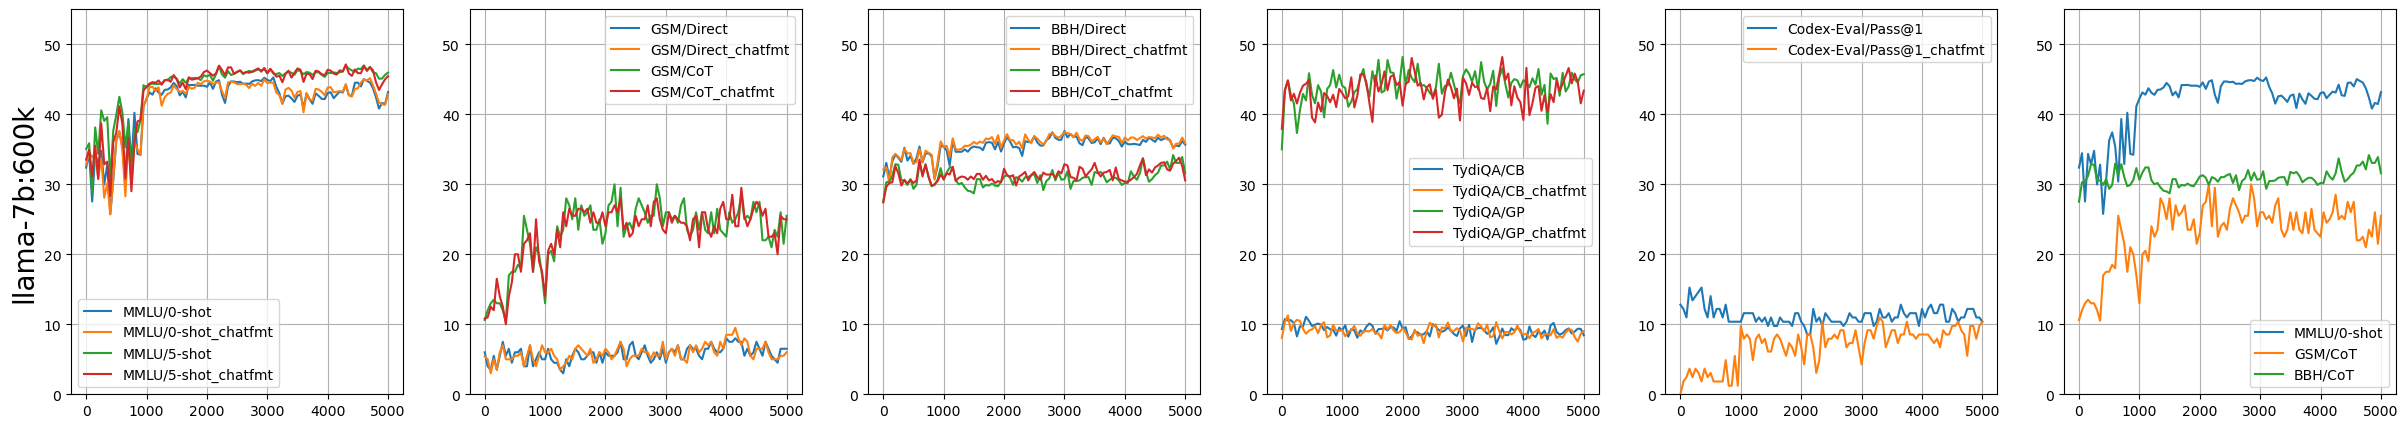

In [89]:
ylabel = 'llama-7b:600k'


exp_dir = '../results/oi3'
save_dirs = [('llama-7b', '../results/baselines/huggyllama/llama-7b/')]
save_dirs += [(os.path.basename(x), x) for x in 
             glob.glob(os.path.join(exp_dir, 'llama-7b_all:600k_humanmix', 'checkpoint-*'))]
df = get_eval_results(save_dirs, chat_fmt=None, ft_args_fields=ft_args_fields)

dfc = df.copy()

# add base model performance
dfc.loc[dfc['model_args.model_name_or_path']=='huggyllama/llama-7b', 'model_args.model_name_or_path'] = 'checkpoint-0'
# get steps 
dfc.insert(0, 'steps', dfc['model_args.model_name_or_path'].apply(lambda x: int(x.split('-')[-1])))
dfc = dfc.sort_values('steps')


y_labels_list = [
    ['MMLU/0-shot',
     'MMLU/0-shot_chatfmt',
     'MMLU/5-shot',
     'MMLU/5-shot_chatfmt',
    ],
    ['GSM/Direct',
     'GSM/Direct_chatfmt',
     'GSM/CoT', 
     'GSM/CoT_chatfmt', 
    ],
    ['BBH/Direct',
     'BBH/Direct_chatfmt',
     'BBH/CoT',
     'BBH/CoT_chatfmt',
    ],
    ['TydiQA/CB',
     'TydiQA/CB_chatfmt',
     'TydiQA/GP',
     'TydiQA/GP_chatfmt',
    ],
    ['Codex-Eval/Pass@1',
     'Codex-Eval/Pass@1_chatfmt'],
    ['MMLU/0-shot',
     'GSM/CoT',
     'BBH/CoT',],
]

N = len(y_labels_list)

fig, axs = plt.subplots(1,N,figsize=(5*N,5))

axs[0].set_ylabel(ylabel, fontsize=20)

for axi, y_labels in enumerate(y_labels_list):
    ax = axs[axi]

    x = dfc['steps']
    y_list = []
    for y_label in y_labels:
        if y_label not in dfc.columns: continue
        y = dfc[y_label].to_numpy()
        y_list.append(y)
        ax.plot(x, y, label=y_label)
    
    ax.legend()
    ax.grid()
    ax.set_ylim(0, 55)
    
    
# for y_label in ['MMLU/0-shot', 'MMLU/5-shot', 'GSM/Direct', 'GSM/CoT', 'BBH/Direct', 'BBH/CoT', 'TydiQA/CB', 'TydiQA/GP', 'Codex-Eval/Pass@1']:
    
#     for chat_fmt in ['', 'chatfmt']:
#         col = '_'.join([y_label, chat_fmt]) if chat_fmt else y_label
#         y = dfc[col].to_numpy()
#         print(f'{col}\t{y.mean():.2f}')

    

,run_name,model_args.model_name_or_path,data_args.subsample_mixture,MMLU/0-shot,MMLU/0-shot_chatfmt,MMLU/5-shot,MMLU/5-shot_chatfmt,GSM/Direct,GSM/Direct_chatfmt,GSM/CoT,...,BBH/Direct,BBH/Direct_chatfmt,BBH/CoT,BBH/CoT_chatfmt,Codex-Eval/Pass@1,Codex-Eval/Pass@1_chatfmt,TydiQA/CB,TydiQA/CB_chatfmt,TydiQA/GP,TydiQA/GP_chatfmt
0,llama-7b,huggyllama/llama-7b,{},31.861558,32.459764,35.222903,33.057969,6.0,5.5,10.5,...,31.652294,32.970313,29.243182,28.425926,11.585366,0.0,9.50548,10.349886,40.403106,38.564264


In [ ]:
import numpy as np

x_labels = [
    'Answer:\n<|assistant|>\nThe answer is:',
    'Answer:\n<|assistant|>\n',
    '<|assistant|>\nAnswer:',
    '<|assistant|>\nThe answer is:',
]
x_labels = [f'v{i+1}:\n{x}' for i,x in enumerate(x_labels)]

dfc = df.copy()
dfc = df.filter(regex='_v|run')

runs = dfc['run_name'].to_list()[::-1]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for axi, task in enumerate(['MMLU/0-shot', 'MMLU/5-shot']):

    ax = axs[axi]
    cols = [f'{task}_v{x}' for x in [1, 2, 3, 4]]
    x = np.arange(len(x_labels))

    width = .25
    multiplier = 0

    for run in runs:
        offset = width*multiplier
        y = dfc[dfc['run_name']==run][cols].to_numpy().squeeze()
        rects = ax.bar(x+offset, y, width, label=run)
        ax.bar_label(rects, padding=3, fmt='{:.2f}')
        multiplier += 1

    ax.set_title(task)
    ax.set_xticks(x+width)
    ax.set_xticklabels(x_labels, rotation=45, ha='right')
    ax.legend(loc='upper left')
    ax.set_ylim(0, 60)



In [ ]:

total_data_points = 200000 # 10000, 50000, 100000, 200000
subsample_mixture_list = []
subsample_mixture_list += [
    dict((k, int(v*total_data_points)) for k, v in
    {'cot': 0.48785105, 'flan_v2': 0.48785105, 'dolly': 0.00732313, 'oasst1': 0.01697478}.items())
] # humanmix mixture.
subsample_mixture_list += [
    dict((k, int(v*total_data_points)) for k, v in
    {"cot": 0.360595703125, "dolly": 0.0021991729736328125, "flan_v2": 0.63037109375, "oasst1": 0.0016956329345703125}.items())
] # pythia-1.4b humanmix_uniform:200k_doremiv1.json

subsample_mixture_list += [
    dict((k, int(v*total_data_points)) for k, v in
    {"cot": 0.2254638671875, "dolly": 0.01409149169921875, "flan_v2": 0.1739501953125, "oasst1": 0.59423828125}.items())
] # pythia-1.4b humanmix_uniform:200k_doremiv2.json

subsample_mixture_list += [
    dict((k, int(v*total_data_points)) for k, v in
    {"cot": 0.08563232421875, "dolly": 0.54296875, "flan_v2": 0.347900390625, "oasst1": 0.0103302001953125}.items())
] # llama-7b_humanmix_uniform:200k_doremiv2.json
subsample_mixture_list += [
    dict((k, int(v*total_data_points)) for k, v in
    {"cot": 0.0316162109375, "dolly": 0.204833984375, "flan_v2": 0.40966796875, "oasst1": 0.40966796875}.items()
        )] # llama-7b_humanmix_uniform:600k_doremiv2.json
subsample_mixture_list

In [ ]:
6323+40966+81933+81933

In [ ]:
# exp_dir = 'results/ft1'

# d = {
#     'bbh_s=0': 'bbh_s=3',
#     'gsm': 'gsm_s=8_cot',
#     'mmlu': 'mmlu_s=0',
#     'tydiqa_cb': 'tydiqa_s=1_cb',
#     'tydiqa_gp': 'tydiqa_s=1_gp',
# }

# d.update({k+'_chatfmt': v+'_chatfmt' for k,v in d.items()})

# for subdir in os.listdir(exp_dir):    
#     for task_name_src, task_name_tgt in d.items():
#         path_src = os.path.join(exp_dir, subdir, 'eval', task_name_src)
#         path_tgt = os.path.join(exp_dir, subdir, 'eval', task_name_tgt)
#         if os.path.isdir(path_src):
# #             os.rename(path_src, path_tgt)
#             print(path_src)
#             print(path_tgt)


In [ ]:

dfc = df.copy()
dfc.insert(0, 'total_train_samples',  dfc['data_args.subsample_mixture'].apply(
    lambda d: sum(list(d.values())) if d else 200000))
# dfc[dfc['total_train_samples'].apply(
#     lambda x: total_train_samples-500<x<total_train_samples+500)]
dfc

In [ ]:


dfc = df.copy()
dfc.columns = [x.split('_')[0] for x in dfc.columns]
def get_dataset(x):
    x = x.split('+')
    if len(x) == 1:
        return ''
    else:
        d = x[1]
        d = d.replace('_', '')
        return d
dfc['Dataset'] = dfc['Model'].apply(get_dataset)
order_list = ['',
 'superni', 'cot', 'flanv2', 'dolly', 'oasst1',
 'selfinstruct', 'unnaturalinstructions', 'stanfordalpaca', 'codealpaca', 'gpt4alpaca',
 'baize', 'sharegpt', 'humanmix', 'h+gptmix']
dfc['order'] = dfc['Dataset'].map({v: i for i, v in enumerate(order_list)})
dfc = dfc.sort_values('order')
dfc = dfc.drop(columns=['order', 'Dataset'])
dfc = dfc.reset_index(drop=True)

display(dfc[dfc['Model'].apply(lambda x: 'llama-7b' in x and ':' not in x)]
        .style
        .background_gradient(cmap ='coolwarm')
        .format(precision=1))


display(dfc[dfc['Model'].apply(
            lambda x: 'llama-7b' in x and (
                ':' in x or any(c in x for c in ['dolly', 'oasst1', 'cot', 'flan'])
                or 'humanmix' in x
            )
        )]
        .style
        .background_gradient(cmap ='coolwarm')
        .format(precision=1))

display(dfc[dfc['Model'].apply(lambda x: 'llama2-7b' in x or 'llama-7b'==x)]
        .style
        .background_gradient(cmap ='coolwarm')
        .format(precision=1))


In [ ]:
{"dataset": "flan_v2", "id": "flan_v2_2", "messages": [{"role": "user", "content": "Tratatul de la Lisabona nu face inutil referire, pentru prima dată în istoria Uniunii Europene, la drepturile persoanelor care aparţin acestor minorităţi şi la valorile proprii acestora.\n\nWhich language is this?\n"}, {"role": "assistant", "content": "Romanian"}]}
{"dataset": "flan_v2", "id": "flan_v2_2", "messages": [{"role": "user", "content": "Tratatul de la Lisabona nu face inutil referire, pentru prima dat\u0103 \u00een istoria Uniunii Europene, la drepturile persoanelor care apar\u0163in acestor minorit\u0103\u0163i \u015fi la valorile proprii acestora.\n\nWhich language is this?\n"}, {"role": "assistant", "content": "Romanian"}]}


In [ ]:
with pd.option_context('display.float_format', '{:0.1f}'.format):
    display(df[['Model']+[x for x in df.columns if 'chatfmt' in x]])

In [ ]:
with pd.option_context('display.float_format', '{:0.3f}'.format):
    display(df[[x for x in df.columns if 'chatfmt' not in x]])


In [ ]:
import glob

models = []
models += ['t5-small', 't5-base', 't5-large', 't5-3b', 't5-11b']
models += ['huggyllama/llama-7b']
save_dirs = [f'../results/baselines/{x}/eval/gsm/' for x in models]

data = []
for model, save_dir in zip(models, save_dirs):
    logfile_path = glob.glob(os.path.join(save_dir, '*.out'))[0]
    out = get_run_statistics(logfile_path)
    with open(os.path.join(save_dir, 'metrics.json'), 'r') as f:
        metrics = json.load(f)
    data.append((model, out['cpu_time']/60/60, out['avg_mem'], out['max_mem'], metrics['exact_match']))
    

import pandas as pd
columns = ['name', 'cpu_time (hr)', 'avg_mem', 'max_mem', 'exact_match']
df = pd.DataFrame(data, columns=columns)
df

In [ ]:


df

